In [1]:
import numpy as np
import matplotlib.pyplot as plt
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.Analysis.lens_profile import LensProfileAnalysis
from lenstronomy.Util import util, param_util

from coolest.api.profiles.mass import PEMD

### Show that lenstronomy kappa grid is the same as COOLEST PEMD

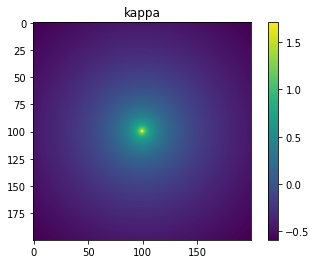

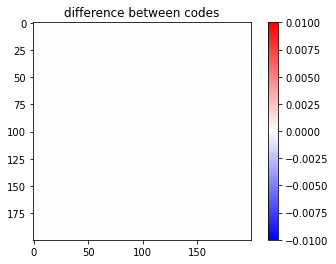

maximum difference:  2.0267520994821098e-10


In [2]:
lens_model_list=['PEMD']
phi=0
q=1
e1,e2 = param_util.phi_q2_ellipticity(phi,q)
kwargs_lens=[{'theta_E':3.637, 'gamma':2, 'e1':e1, 'e2':e2, 'center_x':0, 'center_y':0}]
lens_model = LensModel(lens_model_list)

grid_num=200 #lenstronomy default is 200 to calculate R_Ein
delta_pix_image=0.05 #lenstronomy default is 0.05 to calculate R_Ein
x_, y_ = np.linspace(-delta_pix_image*grid_num/2, delta_pix_image*grid_num/2, grid_num), np.linspace(-delta_pix_image*grid_num/2, delta_pix_image*grid_num/2, grid_num)
x_grid, y_grid = np.meshgrid(x_, y_)

# Create kappa on a grid
coolest_kappa_image = PEMD().convergence(x_grid, y_grid,
                            theta_E=kwargs_lens[0]['theta_E'], gamma=kwargs_lens[0]['gamma'], 
                            phi=phi, q=q,
                            center_x=kwargs_lens[0]['center_x'], center_y=kwargs_lens[0]['center_y'])
lenstronomy_kappa_image=util.array2image(lens_model.kappa(x_grid.flatten(),y_grid.flatten(), kwargs_lens))

plt.imshow(np.log10(coolest_kappa_image))
plt.title('kappa')
plt.colorbar()
plt.show()
plt.imshow(lenstronomy_kappa_image-coolest_kappa_image,cmap='bwr',vmin=-0.01, vmax=0.01)
plt.title('difference between codes')
plt.colorbar()
plt.show()
print('maximum difference: ',np.max(np.abs(lenstronomy_kappa_image-coolest_kappa_image)))

### lenstronomy Einstein radius, analytical Einstein radius

lenstronomy's method evaluates kappa on a grid, creates a circular mask starting from innermost pixel and expanding outwards. Stops when mean kappa within mask = 1

In [3]:
lens_an= LensProfileAnalysis(lens_model)
r_Ein_eff,r_Ein_error=lens_an.effective_einstein_radius(kwargs_lens,get_precision=True)
print('lenstronomy: ',r_Ein_eff, '+/-' ,r_Ein_error)

#theta_E is the analytical solution, for circular profiles (is off for elliptical cases)
analytical_R_E=kwargs_lens[0]['theta_E']
print('analytical: ',analytical_R_E)

lenstronomy:  3.634085213032581 +/- 0.012531328320802004
analytical:  3.637


### my method

The difference between my method and lenstronomy is that I start from an initial guess, then expand the mask either inwards or outwards, saving a few iterations and avoiding repeating the sum. I also start with larger steps and reduce the step size when close.

It may be possible to include a target precision argument, which is used to create the kappa grid. This wouldn't work when the interpolated grid is provided.

In [4]:

def effective_einstein_radius(kappa_image, x, y, initial_guess=1,
                              center_x=0, center_y=0, initial_delta=None, n_iter=5):
    """
    Calculates Einstein radius for a kappa grid starting from an initial guess with large step size and zeroing in from there
    
    :param kappa_image: pixelated grid with convergence values
    :param x: grid of x coordinates for kappa_image pixels
    :param y: grid of y coordinates for kappa_image pixels
    :param initial_guess: initial guess for Einstein radius, default = 1
    :param center_x: x-coordinate of center from which to calculate Einstein radius
    :param center_y: y-coordinate of center from which to calculate Einstein radius
    :param initial delta: initial step size before shrinking in future iterations, default = 10 pixels
    :param n_iter: number of iterations, default = 5
    """
    
    
    def loop_until_overshoot(r_Ein, delta, direction, runningtotal, total_pix):
        """
        this function iteratively adjusts the mask radius by delta either inward or outward until the sign flips on mean_kappa-area
        """
        loopcount=0
        if r_Ein==np.nan: #return nan if given nan (needed when I put this in a loop below)
            return np.nan, np.nan, 0, runningtotal, total_pix
        while (runningtotal-total_pix)*direction>0:
            if loopcount > 100:
                raise Warning('Stuck in very long (possibly infinite) loop')
                break
            if direction > 0:
                mask=only_between_r1r2(r_Ein, r_Ein+delta,r_grid)
            else:
                mask=only_between_r1r2(r_Ein-delta, r_Ein, r_grid)
            kappa_annulus=np.sum(kappa_image[mask])
            added_pix=np.sum(mask)
            runningtotal=runningtotal+kappa_annulus*direction
            total_pix=total_pix+added_pix*direction
            r_Ein=r_Ein+delta*direction 
            
            if r_Ein < min_guess: 
                #Either we overshot into the center region between pixels (rare), or kappa is subcritical.
                #check starting from zero
                mask=only_between_r1r2(0,min_guess,r_grid)
                runningtotal=np.sum(kappa_image[mask])
                total_pix=np.sum(mask)
                if runningtotal-total_pix < 0:
                    print('WARNING: kappa is sub-critical, Einstein radius undefined.')
                    return np.nan, np.nan, 0, runningtotal, total_pix
            loopcount+=1
        return r_Ein, delta, direction, runningtotal, total_pix

    def only_between_r1r2(r1, r2, r_grid):
        if r1 > r2:
            raise ValueError('r2 must be greater than r1')
        return (r_grid >= r1) & (r_grid < r2)
    
    
    #some initialization: if there is an even number of pixels we don't want to be stuck in the center between 4 pixels.
    grid_res=np.abs(x[0,0]-x[0,1])
    if initial_delta==None:
        initial_delta=grid_res*10 #default inital step size is 5 pixels
    min_guess=grid_res*np.sqrt(2)+1e-6
    initial_guess=max(initial_guess,min_guess) #initial guess must include at least one pixel
    
    r_grid=np.sqrt((x-center_x)**2+(y-center_y)**2)
    mask=only_between_r1r2(0,initial_guess,r_grid)
    runningtotal=np.sum(kappa_image[mask])
    total_pix=np.sum(mask)
    if runningtotal > total_pix: #move outward
        direction=1
    elif runningtotal < total_pix: #move inward
        direction=-1
    else:
        return initial_guess
    r_Ein=initial_guess
    delta=initial_delta
    
    for n in range(n_iter):
        #overshoots, turn around and backtrack at higher precision
        r_Ein, delta, direction, runningtotal, total_pix = loop_until_overshoot(r_Ein, delta, direction, runningtotal, total_pix)
        direction=direction*-1
        delta=delta/2
    accuracy=grid_res/2 #after testing, accuracy is about grid_res/2
    if np.isnan(r_Ein):
        accuracy=np.nan
    return r_Ein, accuracy 

### speed comparison

For small $\theta_E$, my method is 2-3 times faster than lenstronomy. It scales better for larger $\theta_E$: roughly 6 times faster for $\theta_E \sim$ 3. 

Accuracy is comparable, although I use a finer grid for my method.

In [5]:
#time test
import time


lens_model_list=['PEMD']
phi=0
q=1
e1,e2 = param_util.phi_q2_ellipticity(phi,q)
kwargs_lens=[{'theta_E':0.637, 'gamma':2, 'e1':e1, 'e2':e2, 'center_x':0, 'center_y':0}]
print('analytical value: ', kwargs_lens[0]['theta_E'])
print()
lens_model = LensModel(lens_model_list)
starttime=time.time()
r_Ein_eff,r_Ein_error=lens_an.effective_einstein_radius(kwargs_lens,get_precision=True)
print('---lenstronomy---')
print('value: ', r_Ein_eff, '+/-' ,r_Ein_error)
print('runtime:', time.time()-starttime)

print()
starttime=time.time()
grid_num=400 #lenstronomy default is 200
delta_pix_image=0.02 #lenstronomy default is 0.05
x_, y_ = np.linspace(-delta_pix_image*grid_num/2, delta_pix_image*grid_num/2, grid_num), np.linspace(-delta_pix_image*grid_num/2, delta_pix_image*grid_num/2, grid_num)
x_grid, y_grid = np.meshgrid(x_, y_)
coolest_kappa_image = PEMD().convergence(x_grid, y_grid,
                            theta_E=kwargs_lens[0]['theta_E'], gamma=kwargs_lens[0]['gamma'], 
                            phi=phi, q=q,
                            center_x=kwargs_lens[0]['center_x'], center_y=kwargs_lens[0]['center_y'])
r_Ein, error = effective_einstein_radius(coolest_kappa_image,x_grid,y_grid)
print('---my version---')
print('value: ', r_Ein, '+/-' ,error)
print('runtime:', time.time()-starttime)

print()
print('::::::::::::::::::::::::::::::::::::::::::::::::::')
print()
kwargs_lens=[{'theta_E':3.637, 'gamma':2, 'e1':e1, 'e2':e2, 'center_x':0, 'center_y':0}]
print('analytical value: ', kwargs_lens[0]['theta_E'])
print()
lens_model = LensModel(lens_model_list)
starttime=time.time()
r_Ein_eff,r_Ein_error=lens_an.effective_einstein_radius(kwargs_lens,get_precision=True)
print('---lenstronomy---')
print('value: ', r_Ein_eff, '+/-' ,r_Ein_error)
print('runtime:', time.time()-starttime)

print()

starttime=time.time()
grid_num=400 #lenstronomy default is 200
delta_pix_image=0.02 #lenstronomy default is 0.05
x_, y_ = np.linspace(-delta_pix_image*grid_num/2, delta_pix_image*grid_num/2, grid_num), np.linspace(-delta_pix_image*grid_num/2, delta_pix_image*grid_num/2, grid_num)
x_grid, y_grid = np.meshgrid(x_, y_)
coolest_kappa_image = PEMD().convergence(x_grid, y_grid,
                            theta_E=kwargs_lens[0]['theta_E'], gamma=kwargs_lens[0]['gamma'], 
                            phi=phi, q=q,
                            center_x=kwargs_lens[0]['center_x'], center_y=kwargs_lens[0]['center_y'])
r_Ein, error = effective_einstein_radius(coolest_kappa_image,x_grid,y_grid)
print('---my version---')
print('value: ', r_Ein, '+/-' ,error)
print('runtime:', time.time()-starttime)



analytical value:  0.637

---lenstronomy---
value:  0.6265664160401002 +/- 0.012531328320802004
runtime: 0.024131059646606445

---my version---
value:  0.62406015037594 +/- 0.010025062656641603
runtime: 0.009778022766113281

::::::::::::::::::::::::::::::::::::::::::::::::::

analytical value:  3.637

---lenstronomy---
value:  3.634085213032581 +/- 0.012531328320802004
runtime: 0.0902719497680664

---my version---
value:  3.6315789473684212 +/- 0.010025062656641603
runtime: 0.011593818664550781
